Load input. Normalized proteomics from CCLE was downloaded from [here](https://gygi.hms.harvard.edu/data/ccle/protein_quant_current_normalized.csv.gz) and normalized by Arjana Begzati using Perseus by downshift Gaussian distribution sampling. 

Metastatic potential was obtained from [Metmap 500](https://depmap.org/metmap/data/index.html).

In [31]:
import os
from tqdm import trange
from collections import Counter

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer


import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
seed = 42
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'

In [33]:
mp = pd.read_excel(os.path.join(data_path, 'raw', 'Supplementary Table 04 MetMap 500 met potential.xlsx'), 
                   sheet_name = 'metp500.all5', index_col = 0)

md = pd.read_csv(os.path.join(data_path, 'raw', 'Model.csv'), index_col = 0)

expr = pd.read_csv(os.path.join(data_path, 'interim', 
                                'TableS2_PepNumbColsRemoved_80pSamplesMissingProtsRemoved_Imputed.csv'), 
                          index_col = None)


Format expression matrix:

In [34]:
# expr.drop(index = 0, inplace = True)
# expr.reset_index(inplace = True, drop = True)

expr.set_index('Protein_Id', inplace = True)
expr.drop(columns = ['Uniprot', '#Imputations'], inplace = True)

# drop samples repeated across templex
columns = ['_'.join(col.split('_')[:-1]) for col in expr.columns]
counts = Counter(columns)
duplicate_samples = [x for x in columns if counts[x] > 1]
print('{} non-unique samples across {} templexes are repeated and will be dropped'.format(len(set(duplicate_samples)), 
                                                                              len(duplicate_samples)))
duplicate_sample_ids = [col for col in expr.columns if '_'.join(col.split('_')[:-1]) in duplicate_samples]
expr.drop(columns = duplicate_sample_ids, inplace = True)

# format column names to match metastatic potential
expr.columns = ['_'.join(col.split('_')[:-1]) for col in expr.columns]
expr = expr.T

3 non-unique samples across 6 templexes are repeated and will be dropped


Retain overlapping samples between the expression nad metastatic potential dataset:

In [36]:
intersect_samples = sorted(set(expr.index).intersection(mp.index))
n_samples_expr_og = expr.shape[0]
print('{} samples overlap betwee the {} in the expression dataset and the {} in the metastatic potential dataset'.format(len(intersect_samples), expr.shape[0], mp.shape[0]))

mp = mp.loc[intersect_samples, :]
expr = expr.loc[intersect_samples, :]



248 samples overlap betwee the 372 in the expression dataset and the 488 in the metastatic potential dataset


Look at the data distributions:

In [37]:
stats_novst = pd.DataFrame({'mean': expr.mean(axis = 0), 'variance': expr.var(axis = 0)})
# stats_novst.reset_index(drop=True, inplace = True)

''

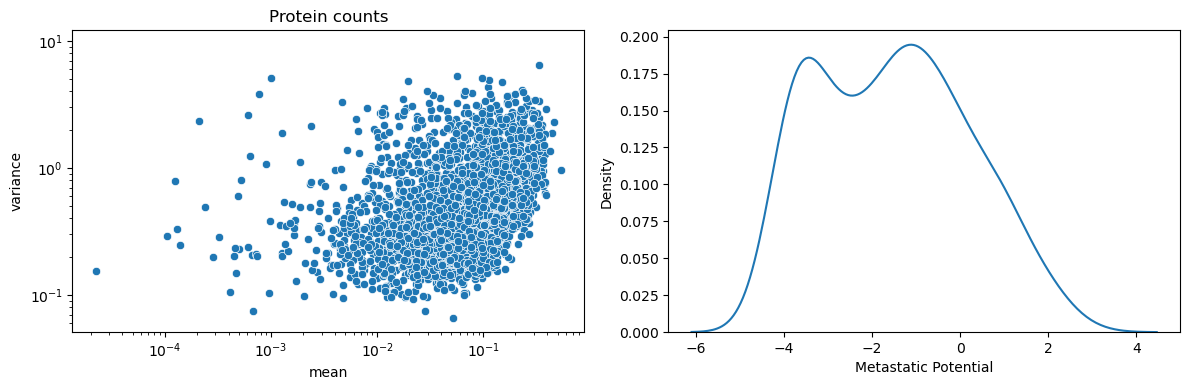

In [38]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
ax = ax.flatten()

# subplot 1
i = 0
sns.scatterplot(data = stats_novst, x = 'mean', y = 'variance', ax = ax[i])
ax[i].set_xscale('log')
ax[i].set_yscale('log')
ax[i].set_title('Protein counts')

# subplot 2
# i += 1
# sns.scatterplot(data = stats, x = 'mean', y = 'variance', ax = ax[i])
# ax[i].set_xscale('symlog')
# ax[i].set_yscale('log')
# ax[i].set_title('VST counts')
# ax[i].yaxis.set_major_locator(ticker.FixedLocator([0.01, 0.1, 1, 10]))
# ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

# # subplot 3
# i+=1
# sns.kdeplot(nexpr.sum().tolist(), ax = ax[i])
# ax[i].set_xlabel('Sample-wise TPM Count Sum')
# # ax[i].set_xscale('log')

# subplot 4
i+=1
sns.kdeplot(data=mp, x='mean', ax = ax[i])
ax[i].set_xlabel('Metastatic Potential')

fig.tight_layout()
;

In [40]:
mp.to_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'))
expr.to_csv(os.path.join(data_path, 'processed', 'expr_protein.csv'))